<h1 align='center'><u>Spam Detection HW - File2</u></h1>

In [ ]:
!pip install feature-engine -qq

     |████████████████████████████████| 205 kB 7.4 MB/s 
     |████████████████████████████████| 9.8 MB 3.7 MB/s 


In [ ]:
!pip install -U spacy -qq

     |████████████████████████████████| 6.0 MB 6.1 MB/s 
     |████████████████████████████████| 628 kB 47.4 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 181 kB 46.6 MB/s 
     |████████████████████████████████| 10.1 MB 35.3 MB/s 
     |████████████████████████████████| 451 kB 37.4 MB/s 


In [ ]:
!python -m spacy download 'en_core_web_sm' -qq

     |████████████████████████████████| 13.9 MB 7.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install pyspellchecker -qq

     |████████████████████████████████| 2.7 MB 8.3 MB/s 


In [ ]:
from pathlib import Path
from google.colab import drive
import sys
drive.mount('/content/drive')
data_folder = Path('/content/drive/MyDrive/Lec4-SentimentAnalysis/HW3/data')

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/NLP/custom_functions')

In [ ]:
model_folder = Path('/content/drive/MyDrive/NLP/models')

In [ ]:
# Import Libraries
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from plot_learning_curve import plot_learning_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from  sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from featurizer import ManualFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import custom_preprocessor as cp
import pandas as pd
import numpy as np
import spacy
import joblib

In [ ]:
# load spacy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
df = pd.read_csv(data_folder / 'spam.csv', encoding='ISO-8859-1')

In [ ]:
# Remove unnecessary columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename columns as label and message
df.columns = ['label', 'message']

In [ ]:
le = LabelEncoder()
le.fit(df['label'])

df['label_encoded'] = le.transform(df['label'])

In [ ]:
X, y = df['message'].values, df['label_encoded'].values

In [ ]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Training the chosen final pipeline on entire training data

**Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline**
* Used TF_IDF vectorizer for sparse embeddings
* Featurization
* Used Weighted XGBoost Classifier as ML Model to address class imbalance 

RandomizedSearch followed by HalvingGridSearch to find best hyperparams



In [ ]:
# Change all words to lowercase
# Remove stop words, punctuations, URLs
# Lammetize words
X_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', lower=True, remove_stop=True, remove_punct=True, remove_url=True, lammetize=True).transform(X)

In [ ]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
X_features, feature_names  = featurizer.fit_transform(X)

In [ ]:
X_final = pd.concat((pd.DataFrame(X_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)

In [ ]:
X_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,count_mispelled,count_words_with_all_capitals,noun_count,aux_count,verb_count,adj_count,symbols_count,ner
0,jurong point crazy available bugis n great wor...,20.0,102.0,83.0,4.150000,0.0,0.0,3.0,0.0,0.0,8.0,0.0,2.0,4.0,0.0
1,ok lar joke wif u oni,6.0,23.0,18.0,3.000000,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0
2,free entry 2 wkly comp win fa cup final tkts 2...,26.0,140.0,115.0,4.423077,25.0,6.0,8.0,4.0,4.0,13.0,0.0,4.0,3.0,0.0
3,u dun early hor u c,11.0,43.0,33.0,3.000000,0.0,0.0,1.0,2.0,0.0,4.0,0.0,3.0,1.0,0.0
4,nah think go usf live,14.0,61.0,48.0,3.428571,0.0,0.0,3.0,1.0,1.0,0.0,1.0,4.0,0.0,0.0


In [ ]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cleaned_text                   5572 non-null   object 
 1   count_words                    5572 non-null   float64
 2   count_characters               5572 non-null   float64
 3   count_characters_no_space      5572 non-null   float64
 4   avg_word_length                5572 non-null   float64
 5   count_digits                   5572 non-null   float64
 6   count_numbers                  5572 non-null   float64
 7   count_mispelled                5572 non-null   float64
 8   count_words_with_all_capitals  5572 non-null   float64
 9   noun_count                     5572 non-null   float64
 10  aux_count                      5572 non-null   float64
 11  verb_count                     5572 non-null   float64
 12  adj_count                      5572 non-null   f

In [ ]:
subset = X_final[0:10]

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()),]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)),]) 

In [ ]:
sparse_features.fit_transform(subset.iloc[:,1:])

<10x14 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.fit_transform(subset.iloc[:,0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [ ]:
# Use vectorizer for cleaned_text and sparse_features for everything else
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [ ]:
test = combined_features.fit_transform(subset)

In [ ]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier()),])

In [ ]:
weights    = [1, 10, 25, 50, 75, 99, 100, 1000]

param_dist_classifier_1c = {
              "classifier__max_depth": [2,3,4,5,6],
              "classifier__learning_rate":[0.01,0.02,0.03,0.05,0.1,0.3,0.5],
              "classifier__reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              "classifier__gamma":[i/10.0 for i in range(0,5)],
              "classifier__n_estimators":[100,500,700,1000],
              "classifier__scale_pos_weight":weights,
              'classifier__max_delta_step': range(1,10,1),              
              'combined_features__tfidf__tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),
              'combined_features__tfidf__tfidf__max_features': [None, 500, 800, 1000, 1500, 2000],
              'combined_features__tfidf__tfidf__max_df': [0.8, 0.6, 0.4, 0.2]
              }

In [ ]:
randomized_classifier_1c = RandomizedSearchCV(estimator=classifier_1c, param_distributions=param_dist_classifier_1c, cv = 5, scoring="precision", n_jobs=-1)

In [ ]:
randomized_classifier_1c.fit(X_final, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(max_features=5))]),
                                                                               'cleaned_text')])),
                                             ('classifier', XGBClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__gamma': [0.0, 0.1, 0.2,
                                                              0.3...
            

In [ ]:
print("Best cross-validation score: {:.2f}".format(randomized_classifier_1c.best_score_))
print("\nBest parameters: ", randomized_classifier_1c.best_params_)
print("\nBest estimator: ", randomized_classifier_1c.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'combined_features__tfidf__tfidf__ngram_range': (1, 2), 'combined_features__tfidf__tfidf__max_features': 1000, 'combined_features__tfidf__tfidf__max_df': 0.2, 'classifier__scale_pos_weight': 50, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 500, 'classifier__max_depth': 3, 'classifier__max_delta_step': 9, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.2}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.2,
                                                                                   max_features=1000,
                     

Randomized Search provides us with an approximation of best hyperparameters. For efficiency have performed randomized search first and have further finetuned the obtained hyperparameters by narrowing down using Halving Grid Classifier



In [ ]:
weights    = [40, 50, 60]

param_grid_classifier_1c = {
              "classifier__max_depth": [3, 4],
              "classifier__learning_rate":[0.05, 0.1, 0.2],
              "classifier__reg_alpha":[0.05, 0.1, 0.2],
              "classifier__gamma":[0.15, 0.2, 0.25],
              "classifier__n_estimators":[400,500,600],
              "classifier__scale_pos_weight":weights,
              'classifier__max_delta_step': [8.5, 9, 9.5],              
              'combined_features__tfidf__tfidf__ngram_range': ((1, 1), (1, 2)),
              'combined_features__tfidf__tfidf__max_features': [None, 900, 1000, 1100],
              'combined_features__tfidf__tfidf__max_df': [0.3, 0.2]
              }

In [ ]:
halving_grid_classifier_1c = HalvingGridSearchCV(estimator=classifier_1c, param_grid=param_grid_classifier_1c, cv = 3, scoring="precision", n_jobs=-1)

In [ ]:
halving_grid_classifier_1c.fit(X_final, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan nan nan ...  1.  1.  1.]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.99093499 0.98603827 0.98603827]
  category=User

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('combined_features',
                                               ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                            SparseTransformer())]),
                                                                 transformers=[('tfidf',
                                                                                Pipeline(steps=[('tfidf',
                                                                                                 TfidfVectorizer(max_features=5))]),
                                                                                'cleaned_text')])),
                                              ('classifier', XGBClassifier())]),
                    n_jobs=-1,
                    param_grid={'classifier__gamma': [0.15, 0.2, 0.25],
                                'classif...
                                

In [ ]:
print("Best cross-validation score: {:.2f}".format(halving_grid_classifier_1c.best_score_))
print("\nBest parameters: ", halving_grid_classifier_1c.best_params_)
print("\nBest estimator: ", halving_grid_classifier_1c.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__gamma': 0.2, 'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 9, 'classifier__max_depth': 3, 'classifier__n_estimators': 600, 'classifier__reg_alpha': 0.2, 'classifier__scale_pos_weight': 50, 'combined_features__tfidf__tfidf__max_df': 0.2, 'combined_features__tfidf__tfidf__max_features': None, 'combined_features__tfidf__tfidf__ngram_range': (1, 1)}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.2))]),
                                                  'cleaned_text')])),
                ('classifier',
                 

In [ ]:
file_model_combined = model_folder / 'precision_spam_final_combined_model.pkl'

In [ ]:
joblib.dump(halving_grid_classifier_1c.best_estimator_, file_model_combined)

['/content/drive/MyDrive/NLP/models/precision_spam_final_combined_model.pkl']

In [ ]:
loaded_model_combined = joblib.load(file_model_combined)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

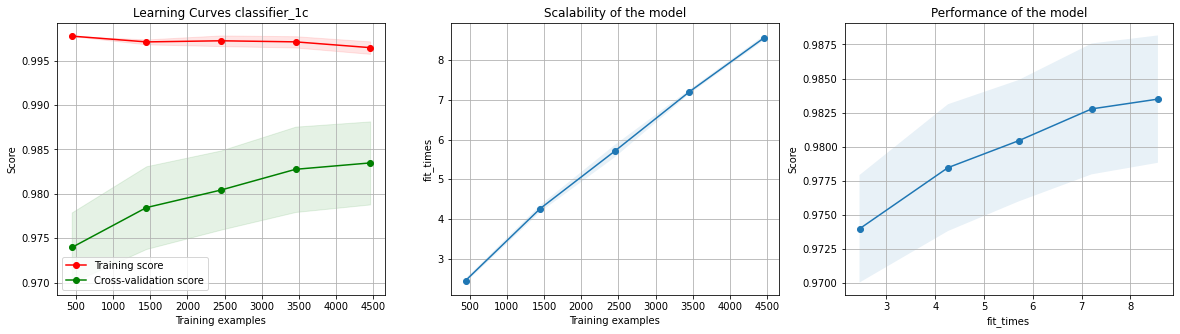

In [ ]:
plot_learning_curve(loaded_model_combined, 'Learning Curves classifier_1c', X_final, y)

With entire dataset overfitting has been controlled as much as possible and the combined pipeline provides us with train score of 0.995 and cross-validation score of 0.984